<a href="https://colab.research.google.com/github/GermanOmar/GPs---WAAM/blob/master/WAAM_AM4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised machine learning algorithms for the layer geometry prediction in plasma wire arc additive manufacturing 


<a href="https://ibb.co/5Rvr5t7"><img src="https://i.ibb.co/kS04hkd/Fig1-4.png" WIDTH="500" HEIGHT="300"  border="0"></a>

 Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing

 Upload database:

In [2]:
!git clone https://github.com/GermanOmar/GPs---WAAM

Cloning into 'GPs---WAAM'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 60 (delta 18), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (60/60), done.


In [3]:
#Experimental data
data = pd.read_table('df4.txt') 
data.describe()



,V,Q*,PGFR,LH,WW
count,25.000000,25.000000,25.00000,25.000000,25.000000
mean,22.956800,1.421360,2.20560,1.653200,7.452800
std,1.158946,0.351795,1.48724,0.215672,0.994793
min,21.030000,0.889000,0.80000,1.290000,5.800000
25%,22.130000,1.207000,0.80000,1.510000,6.700000
50%,23.180000,1.343000,1.70000,1.620000,7.350000
75%,23.840000,1.552000,3.16000,1.810000,8.000000
max,24.760000,2.298000,5.00000,2.070000,9.500000


<a href="https://ibb.co/QrLn5c3"><img src="https://i.ibb.co/XS1pw4r/FIG1-geo.png" WIDTH="500" HEIGHT="325"  border="0"></a>


Setting inputs - output:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


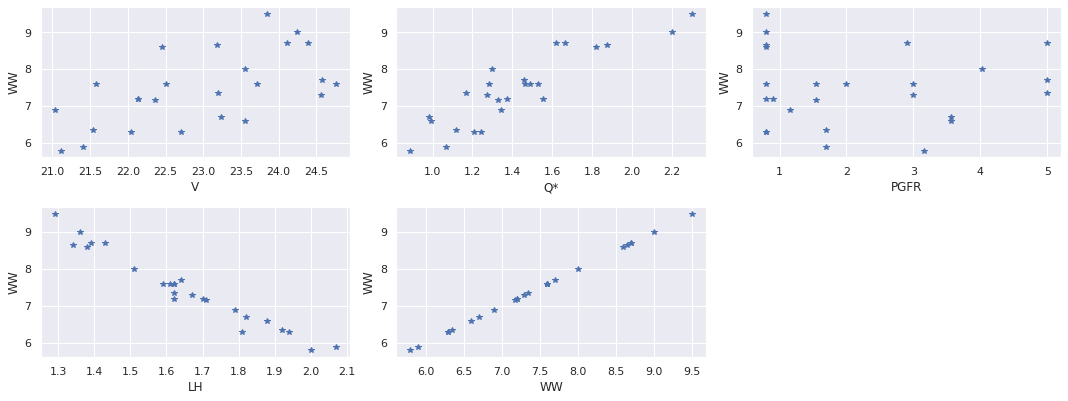

In [4]:
fields = [ 'V', 'Q*','PGFR', 'LH','WW']
import seaborn as sns
sns.set()

fig = plt.figure()
fig.set_size_inches((15,8))
for i, field in enumerate(fields):
  plt.subplot(3, 3, i + 1)
  plt.plot(data[field], data['WW'], 'b*')
  plt.xlabel(field)
  plt.ylabel('WW')

plt.tight_layout()

X=data[[ 'V', 'Q*','PGFR']]
Y=data['WW'][:,None]
Z=data['LH'][:,None]


#fig.tight_layout()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b26ebf128>,
      dtype=object)

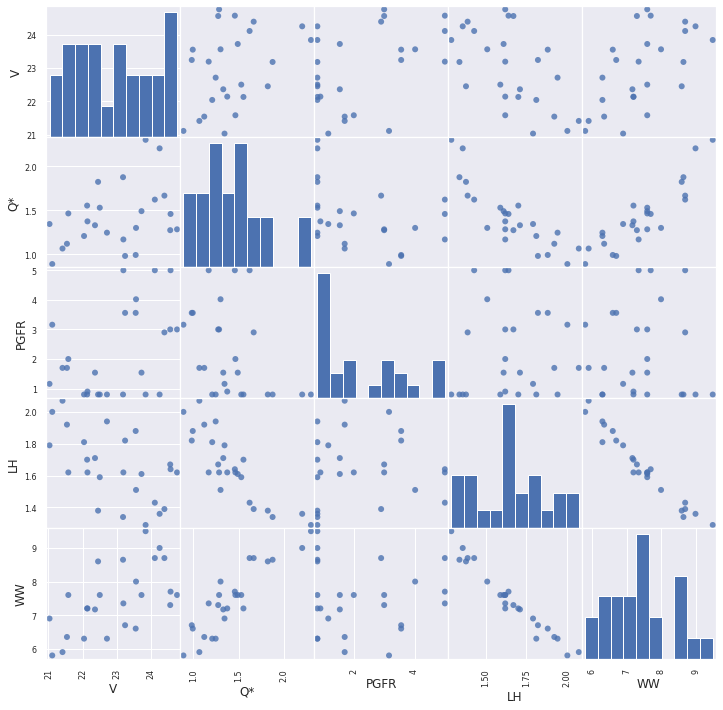

In [6]:
from pandas.plotting import scatter_matrix
#DISPLAY MATRIX - identificar correlacion entre variables
scatter_matrix(data, alpha=0.8, marker='o', figsize = (12,12))
#warnings.filterwarnings("ignore")

#Wall width prediction

In [7]:
def normalize(X, X_mu, X_std):
  return (X - X_mu)/X_std

def denormalize(Xn, X_mu, X_std):
  return Xn*X_std + X_mu

X_std = X.std(0)
X_mu = X.mean(0)
Xn = normalize(X, X_mu, X_std)

Y_std = Y.std(0)
Y_mu = Y.mean(0)
Yn = normalize(Y, Y_mu, Y_std)

 Split data

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.22, random_state=32)
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 19  test samples: 6


In [9]:
pip install lazypredict

In [10]:
from lazypredict.Supervised import LazyRegressor
from sklearn import datasets
from sklearn.utils import shuffle
import numpy as np

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


#Results:

In [11]:
from sklearn.metrics import mean_absolute_error as MAE
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 79%|███████▉  | 31/39 [00:00<00:00, 35.98it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'
[03:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 39/39 [00:01<00:00, 22.05it/s]

                               R-Squared  RMSE  Time Taken
Model                                                     
XGBRegressor                        0.90  0.23        0.92
GradientBoostingRegressor           0.88  0.25        0.03
LinearSVR                           0.84  0.29        0.01
SGDRegressor                        0.84  0.29        0.01
AdaBoostRegressor                   0.84  0.29        0.06
PassiveAggressiveRegressor          0.83  0.30        0.01
DecisionTreeRegressor               0.81  0.31        0.01
Ridge                               0.78  0.34        0.01
HuberRegressor                      0.77  0.35        0.01
BayesianRidge                       0.77  0.35        0.03
RidgeCV                             0.77  0.35        0.01
ElasticNetCV                        0.76  0.35        0.04
LassoCV                             0.76  0.35        0.08
LinearRegression                    0.76  0.35        0.01
RANSACRegressor                     0.76  0.35        0.

#GBR 

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
#KERNEL
#GBR=GradientBoostingRegressor(n_estimators=100, random_state=0)
GBR=GradientBoostingRegressor(n_estimators=5000, random_state=32, learning_rate=0.1 )

#START TRAINING
GBR.fit(X_train,y_train)
#PREDICTION
y_pred=GBR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

 
print("-Gradient boosting regressor-")
print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()


-Gradient boosting regressor-
-----------------------------
MSE test: 0.08367709698279324

R2:  0.841787001503122
RMSE:  0.28926993791749817
MAE:  0.25609515621129847
IM:  0.4174843457077831



# GPs

Gaussian Process
MSE train: 0.007536517142719681
MSE test: 0.10479449441335838
MSE train < MSE test? True

R2_train:  0.9925374305125998
R2_test:  0.80185914921844

R2:  0.80185914921844
RMSE:  0.32371977760612397
MAE:  0.27136140899351185
IM:  0.46657400854820746



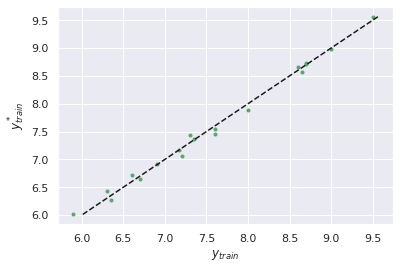

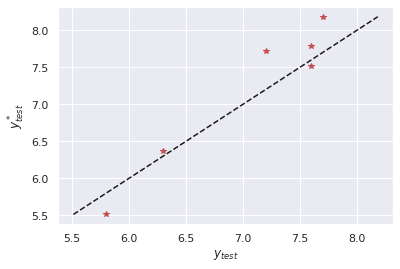

In [27]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
 
GP=GPR(kernel=kernel, n_restarts_optimizer=9, alpha=0.01, normalize_y=True)
 
#Training
GP.fit(X_train,y_train)
 
#Testing
y_star_train = GP.predict(X_train)
y_pred = GP.predict(X_test)
 
#Plots
plt.figure()
plt.plot(y_train, y_star_train, 'g.')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.ylabel('$y^*_{train}$')
plt.xlabel('$y_{train}$')

plt.figure()
plt.plot(y_test, y_pred, 'r*')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Gaussian Process")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)
print()
""" 
RE=100 * abs(y_test - y_pred) / y_test
print('Relative error (%): ',RE)
"""
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 
#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

# RFR

In [15]:
from sklearn.ensemble import RandomForestRegressor
#KERNEL
RFR=RandomForestRegressor(n_estimators=1000,max_depth=20)

#START TRAINING
RFR.fit(X_train,y_train)
#PREDICTION
y_pred=RFR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

-SGD regressor-
-----------------------------
MSE test: 0.15631339050000873

R2:  0.7044494717436811
RMSE:  0.39536488273493475
MAE:  0.337103333333362
IM:  0.5977475743129884



# XGB

In [16]:
import pickle
import xgboost as xgb

xgbr = xgb.XGBRegressor(verbosity=0)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

In [17]:
print(xgbr)



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)


In [18]:
score = xgbr.score(X_test, y_test)  
print("Training score: ", score)

Training score:  0.8978526441084219


In [19]:
print("-XGBRegressor -")
print("------------------")

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

-XGBRegressor -
------------------
MSE test: 0.05402460156043464

R2:  0.8978526441084219
RMSE:  0.23243192887474526
MAE:  0.21932856241861978
IM:  0.3355051447723175



Feature: 0, Score: 0.18462
Feature: 1, Score: 0.76533
Feature: 2, Score: 0.05005


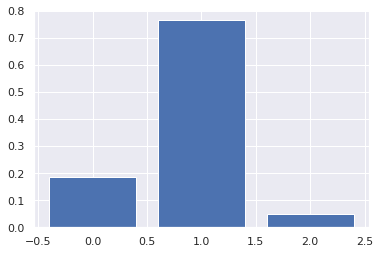

In [20]:
# get importance
importance = xgbr.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# AdaBoost

In [21]:
from sklearn.ensemble import AdaBoostRegressor

print(" AdaBoost -")
print("------------------")

Ada = AdaBoostRegressor(random_state=32, n_estimators=100)
#START TRAINING
Ada.fit(X_train,y_train)
#PREDICTION
y_pred=Ada.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

 AdaBoost -
------------------
MSE test: 0.0845281675170068

R2:  0.8401778345266678
RMSE:  0.2907372826401987
MAE:  0.19982142857142873
IM:  0.3872981995955036



# MLP

In [22]:
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor(hidden_layer_sizes=5,solver='lbfgs',learning_rate='adaptive',activation='relu',random_state=32, max_iter=1000)
#MLP = MLPRegressor(hidden_layer_sizes=(1000,1000,1000), activation='relu', solver='adam', max_iter=800)

#START TRAINING
MLP.fit(X_train,y_train)
#PREDICTION
y_pred=MLP.predict(X_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()



R2:  0.7698839215166215
RMSE:  0.2907372826401987
MAE:  0.2746496938567263
IM:  0.4614260844698408



# DTR

In [23]:
from sklearn.tree import DecisionTreeRegressor
DT=DecisionTreeRegressor(max_depth=20)

#START TRAINING
DT.fit(X_train,y_train)
#PREDICTION
y_pred=DT.predict(X_test)
print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()



R2:  0.8140756302521012
RMSE:  0.2907372826401987
MAE:  0.18333333333333326
IM:  0.39077762204900024



# Linear SVR

In [24]:
from sklearn.svm import LinearSVR

SVR=LinearSVR( tol=0.0001, C=1.0,  fit_intercept=True, intercept_scaling=1.0, dual=True,  random_state=42)

#START TRAINING
SVR.fit(X_train,y_train)
#PREDICTION
y_pred=SVR.predict(X_test)
print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()



R2:  0.7960357024553042
RMSE:  0.2907372826401987
MAE:  0.2917640402085029
IM:  0.4596257796824465



## Comparisson

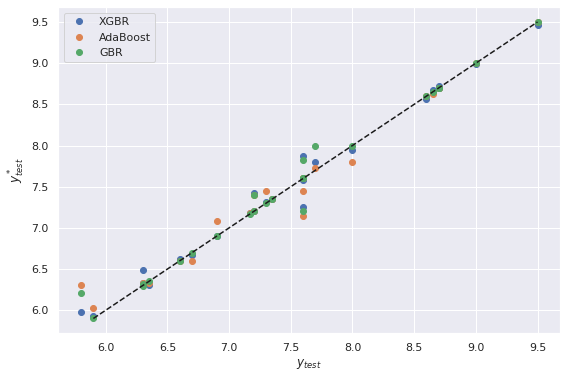

In [30]:
models = [xgbr, Ada, GBR,   ]
labels = ['XGBR', 'AdaBoost', 'GBR']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X)
  plt.plot(Y, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
plt.legend()  
  

Worst

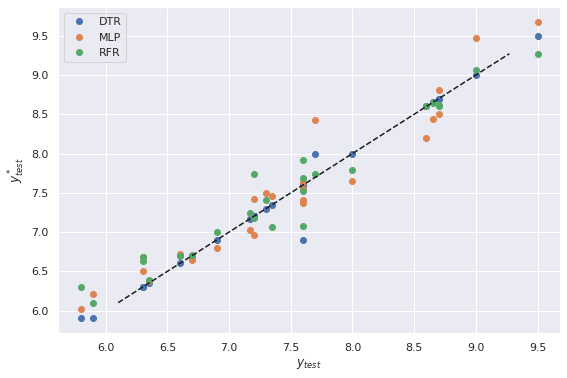

In [31]:
models = [ DT, MLP, RFR  ]
labels = [ 'DTR', 'MLP', 'RFR']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X)
  plt.plot(Y, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
plt.legend()  

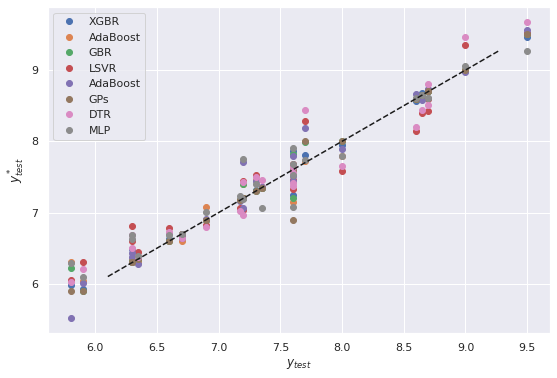

In [29]:
models = [xgbr, Ada, GBR, SVR, GP, DT, MLP, RFR ]
labels = ['XGBR', 'AdaBoost', 'GBR', 'LSVR',  'AdaBoost','GPs', 'DTR', 'MLP', 'RFR']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X)
  plt.plot(Y, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
plt.legend()